이하 코드는 "파이썬으로 배우는 머신러닝의 교과서" 7장 신경망 예제와 설명 정리입니다.

# 2층 피드 포워드 신경망의 구현

In [2]:
import numpy as np

# 이하 데이터 생성

np.random.seed(1)  
N = 200            # 데이터 수
K = 3              # 분포 수
T = np.zeros((N,3), dtype = np.uint8)
X = np.zeros((N,2))

X_range0 = [-3,3]           #x0의 범위
X_range1 = [-3,3]           #x1의 범위
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]])  # 분포의 중심
Sig = np.array([[.7,.7],[.8,.3],[.3,.8]])         # 분포의 분산
Pi = np.array([0.4, 0.8, 1])                      # 각 분포에 대한 비율

for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:      #원핫코드 생성
            T[n,k] = 1
            break
    for k in range(2):
        X[n,k] = np.random.randn() * Sig[T[n,:] ==1,k]+ \
        Mu[T[n,:] == 1,k]


In [3]:
#------------ 데이터를 테스트와 훈련 데이터로 분할

TestRatio = 0.5
X_n_training = int(N*TestRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:,:]
T_train = T[:X_n_training, :]
T_test = T[X_n_training:,:]


#-------------데이터를 'class_data.npz'에 저장
np.savez('class_data.npz', X_train=X_train, T_train=T_train,
        X_test=X_test, T_test=T_test,
        X_range0=X_range0, X_range1=X_range1)

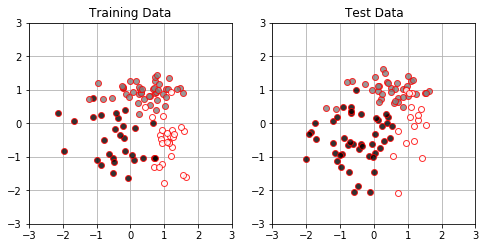

In [4]:
#--------------- 데이터 표현
import matplotlib.pyplot as plt
%matplotlib inline

#--------------- 데이터 표현 함수 정의
def Show_data(x,t):
    wk, n = t.shape
    c = [[0,0,0],[.5,.5,.5],[1,1,1]]
    for i in range(n):
        plt.plot(x[t[:,i]==1,0], x[t[:,i]==1,1],
                linestyle='none',
                marker='o', markeredgecolor='red',
                color=c[i], alpha=0.8)
    plt.grid(True)
    
    
plt.figure(1,figsize=(8,3.7))
plt.subplot(1,2,1)
Show_data(X_train, T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')
plt.subplot(1,2,2)
Show_data(X_test, T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')
plt.show()

In [5]:
# 시그모이드 함수

def Sigmoid(x):
    y = 1/(1+np.exp(-x))
    return y


# 신경망
def FNN(wv, M, K, x):
    N,D = x.shape           # 메인에선 N = 2, D = 2
    w = wv[:M * (D+1)]      
    w = w.reshape(M,(D+1))  # 중간층의 가중치 행렬
    v = wv[M*(D+1):]        # 출력층의 가중치 행렬
    v = v.reshape((K,M+1))   # K=3, M +1 = 3
    b = np.zeros((N,M+1))   # 중간층의 뉴런의 입력 총합
    z = np.zeros((N,M+1))   # 중간층 뉴런의 출력 (시그모이드 활성함수 통과)
    a = np.zeros((N,K))     # 출력층 뉴런의 입력 총합
    y = np.zeros((N,K))     # 출력층 뉴런의 출력 (소프트맥스 통과)
    for n in range(N):
        for m in range(M):
            b[n,m] = np.dot(w[m,:], np.r_[x[n,:],1]) # row 단위로 연결 (바이어스를 붙여줌)
            z[n, m] = Sigmoid(b[n, m]) 
        z[n,M] = 1          # 더미뉴런
        wkz = 0
        for k in range(K):
            a[n,k] = np.dot(v[k,:], z[n,:])
            wkz = wkz + np.exp(a[n,k])        # 소프트맥스 처리과정
        for k in range(K):
            y[n,k] = np.exp(a[n,k]) / wkz    # 소프트맥스 처리
    return y,a,z,b           # 중간 계산 과정들을 출력


# 메인
WV = np.ones(15)
M = 2                      # 중간층의 뉴런수 => 여기선 2층
K = 3                      # 출력의 수
FNN(WV,M,K,X_train[:2,:])

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

In [6]:
# 오차함수인 평균 크로스 엔트로피 계산 함수

def CE_FNN(wv, M,K,x,t):
    N,D = x.shape
    y,a,z,b = FNN(wv,M,K,x)
    ce = -np.dot(np.log(y.reshape(-1)), t.reshape(-1)) / N
    return ce

# test
WV = np.ones(15)
M = 2
K = 3
CE_FNN(WV, M,K,X_train[:2,:], T_train[:2,:])


1.0986122886681098

[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


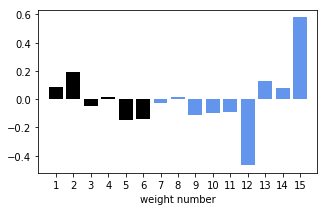

In [7]:
# 수치 미분 적용해보기
def dCE_FNN_num(wv, M, K, x, t):
    e = 0.001                      # epsilon
    dwv = np.zeros_like(wv)
    for iwv in range(len(wv)):
        wv_modified = wv.copy()
        wv_modified[iwv] = wv[iwv] - e
        mse1 = CE_FNN(wv_modified,M,K,x,t)
        wv_modified[iwv] = wv[iwv] + e
        mse2 = CE_FNN(wv_modified,M,K,x,t)
        dwv[iwv] = (mse2 - mse1) / (2*e)
    return dwv

#dVW
def Show_WV(wv, M):
    N = wv.shape[0]
    plt.bar(range(1,M*3+1), wv[:M*3], align="center", color='black') # 중간층 가중치
    plt.bar(range(M*3+1, N+1), wv[M*3:], align="center", color='cornflowerblue')
                                        # 출력층 가중치
    plt.xticks(range(1,N+1))
    plt.xlim(0, N+1)
    plt.xlabel('weight number')
    
#test
M = 2
K = 3
nWV = M * 3 + K * (M+1)
np.random.seed(1)
WV = np.random.normal(0,1,nWV)
dWV = dCE_FNN_num(WV, M, K, X_train[:2,:], T_train[:2,:])
print(dWV)
plt.figure(1, figsize=(5,3))
Show_WV(dWV,M)
plt.show()

# 수치미분 이용
w값 기준에서 아주작은(여기선 0.01) e값을 빼고 더해  
(y값변화량 / x값 변화량) 값으로 기울기(미분값)의 근사치를 구하는 것

In [8]:
import time

# 수치 미분을 이용한 경사하강법
def Fit_FNN_num(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
    wvt = wv_init
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))
    e = 0.001  # epsilon
    
    for i in range(n): # A
        wvt = wvt - alpha * dCE_FNN_num(wvt, M, K, x_train, t_train)
        err_train[i] = CE_FNN(wvt, M, K, x_train, t_train)
        err_test[i] = CE_FNN(wvt,M, K , x_test, t_test)
        wv_hist[i, :] = wvt
    return wvt, wv_hist, err_train, err_test

#메인

startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M*3 + K * (M+1))  # 가중치 초기값
N_step = 1000         # 학습 iteration
alpha = 0.5         # learning rate
WV, WV_hist, Err_train, Err_test = Fit_FNN_num(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime
print("Caclulation time:{0:.3f} sec".format(calculation_time))


Caclulation time:149.321 sec


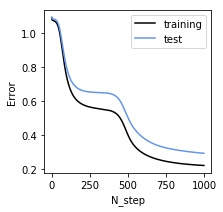

In [9]:
plt.figure(1,figsize=(3,3))
plt.plot(Err_train, 'black', label = 'training')
plt.plot(Err_test, 'cornflowerblue', label = 'test')
plt.xlabel('N_step')
plt.ylabel('Error')
plt.legend()
plt.show()

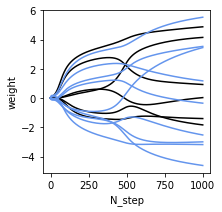

In [10]:
plt.figure(1, figsize=(3,3))
plt.plot(WV_hist[:, :M*3], 'black')
plt.plot(WV_hist[:,M*3:], 'cornflowerblue')
plt.xlabel('N_step')
plt.ylabel('weight')
plt.show()

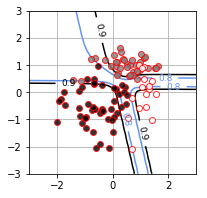

In [11]:
# 경계선 표시 함수 
def show_FNN(wv, M,K):
    xn = 60    #등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0,x1)
    x = np.c_[np.reshape(xx0, xn*xn, 1), np.reshape(xx1,xn * xn, 1)]
    y,a,z,b = FNN(wv,M,K,x)
    plt.figure(1, figsize=(4,4))
    for ic in range(K):
        f = y[:,ic]
        f = f.reshape(xn, xn)
        f = f.T
        cont = plt.contour(xx0, xx1, f, levels=[0.8, 0.9],
                          colors = ['cornflowerblue', 'black'])
        cont.clabel(fmt='%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)

plt.figure(1, figsize=(3,3))
Show_data(X_test, T_test)
show_FNN(WV,M,K)
plt.show()

analytical dWV
[ 0.08848131  0.19158    -0.051398    0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115649 -0.10104422 -0.09427964 -0.46855604
  0.13096434  0.08076649  0.57971253]
numerical dWV
[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


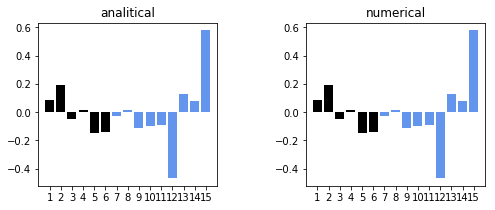

In [12]:
# 리스트 7-1-(11)
# -- 해석적 미분 -----------------------------------
def dCE_FNN(wv, M, K, x, t):
    N, D = x.shape
    # wv을 w와 v로 되돌림
    w = wv[:M * (D + 1)]
    w = w.reshape(M, (D + 1))
    v = wv[M * (D + 1):]
    v = v.reshape((K, M + 1))
    # 1) x를 입력하여 y를 얻음
    y, a, z, b = FNN(wv, M, K, x)
    # 출력 변수의 준비
    dwv = np.zeros_like(wv)
    dw = np.zeros((M, D + 1))
    dv = np.zeros((K, M + 1))
    delta1 = np.zeros(M) # 1층 오차
    delta2 = np.zeros(K) # 2층 오차(k = 0 부분은 사용하지 않음)
    for n in range(N): # (A)
        # 2) 출력층의 오차를 구하기
        for k in range(K):
            delta2[k] = (y[n, k] - t[n, k])
        # 3) 중간층의 오차를 구하기
        for j in range(M):
            delta1[j] = z[n, j] * (1 - z[n, j]) * np.dot(v[:, j], delta2)
        # 4) v의 기울기 dv를 구하기
        for k in range(K):
            dv[k, :] = dv[k, :] + delta2[k] * z[n, :] / N
        # 5) w의 기울기 dw를 구하기
        for j in range(M):
            dw[j, :] = dw[j, :] + delta1[j] * np.r_[x[n, :], 1] / N
    # dw와 dv를 합체시킨 dwv로 만들기
    dwv = np.c_[dw.reshape((1, M * (D + 1))), \
                dv.reshape((1, K * (M + 1)))]
    dwv = dwv.reshape(-1)
    return dwv


#------Show WV
def Show_dWV(wv, M):
    N = wv.shape[0]
    plt.bar(range(1, M * 3 + 1), wv[:M * 3],
            align="center", color='black')
    plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:],
            align="center", color='cornflowerblue')
    plt.xticks(range(1, N + 1))
    plt.xlim(0, N + 1)
    
    
#-- 동작 확인
M = 2
K = 3
N = 2
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)


dWV_ana = dCE_FNN(WV, M, K, X_train[:N, :], T_train[:N, :])
print("analytical dWV")
print(dWV_ana)


dWV_num = dCE_FNN_num(WV, M, K, X_train[:N, :], T_train[:N, :])
print("numerical dWV")
print(dWV_num)


plt.figure(1, figsize=(8, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
Show_dWV(dWV_ana, M)
plt.title('analitical')
plt.subplot(1, 2, 2)
Show_dWV(dWV_num, M)
plt.title('numerical')
plt.show()

# analitical : 오류역전파로 유도한 값들을 이용한 가중치
# numerical : 수치미분을 이용

In [13]:
# 리스트 7-1-(12)
import time


# 해석적 미분을 적용한 경사하강법 
def Fit_FNN(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
    wv = wv_init.copy()
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))
    epsilon = 0.001
    for i in range(n):
        wv = wv - alpha * dCE_FNN(wv, M, K, x_train, t_train) # (A)
        err_train[i] = CE_FNN(wv, M, K, x_train, t_train)
        err_test[i] = CE_FNN(wv, M, K, x_test, t_test)
        wv_hist[i, :] = wv
    return wv, wv_hist, err_train, err_test


# 메인 
startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000
alpha = 1
WV, WV_hist, Err_train, Err_test = Fit_FNN(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

Calculation time:19.502 sec


오류역전파로 유도한 해석적 해를 이용하여 학습시켰더니, 19.5초만에 끝남. 상당히 빨라짐
# 수치미분 : 149s -> 오류역전파 : 19s

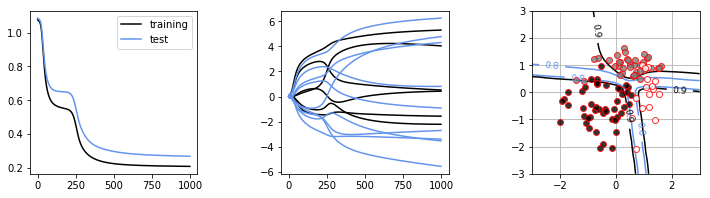

In [14]:
# 리스트 7-1-(13)
plt.figure(1, figsize=(12, 3))
plt.subplots_adjust(wspace=0.5)
# 학습 오차의 표시 ---------------------------
plt.subplot(1, 3, 1)
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label='test')
plt.legend()
# 가중치의 시간 변화 표시 ---------------------------
plt.subplot(1, 3, 2)
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')
# 경계선 표시 --------------------------
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
M = 2
K = 3
show_FNN(WV, M, K)
plt.show()

#  학습 속도가 느려진 곳 -> saddle point(안장점)


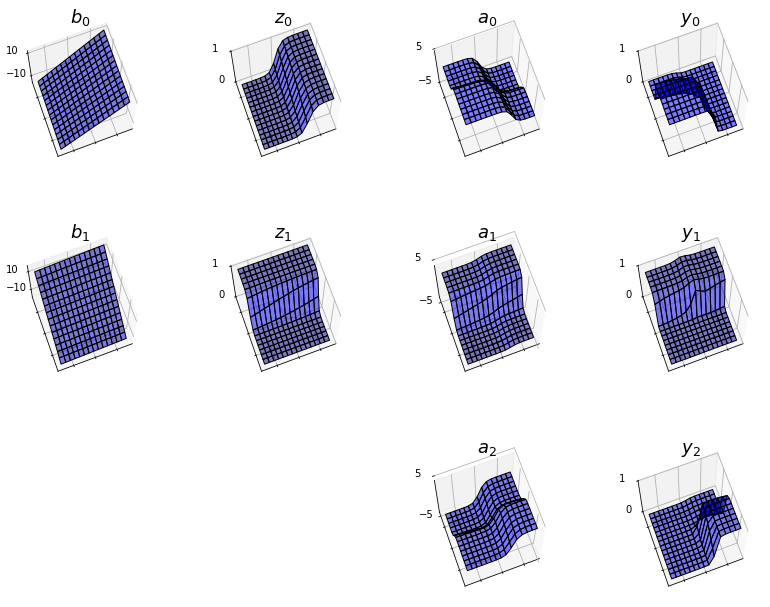

In [23]:
# 리스트 7-1-(14)
from mpl_toolkits.mplot3d import Axes3D


def show_activation3d(ax, v, v_ticks, title_str):
    f = v.copy()
    f = f.reshape(xn, xn)
    f = f.T
    ax.plot_surface(xx0, xx1, f, color='blue', edgecolor='black',
                    rstride=1, cstride=1, alpha=0.5)
    ax.view_init(70, -110)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticks(v_ticks)
    ax.set_title(title_str, fontsize=18)
    
    
M = 2
K = 3
xn = 15 # 등고선 표시 해상도
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
y, a, z, b = FNN(WV, M, K, x)


fig = plt.figure(1, figsize=(12, 9))
plt.subplots_adjust(left=0.075, bottom=0.05, right=0.95,
                    top=0.95, wspace=0.4, hspace=0.4)

for m in range(M):
    ax = fig.add_subplot(3, 4, 1 + m * 4, projection='3d')
    show_activation3d(ax, b[:, m], [-10, 10], '$b_{0:d}$'.format(m))
    ax = fig.add_subplot(3, 4, 2 + m * 4, projection='3d')
    show_activation3d(ax, z[:, m], [0, 1], '$z_{0:d}$'.format(m))
    
    
for k in range(K):
    ax = fig.add_subplot(3, 4, 3 + k * 4, projection='3d')
    show_activation3d(ax, a[:, k], [-5, 5], '$a_{0:d}$'.format(k))
    ax = fig.add_subplot(3, 4, 4 + k * 4, projection='3d')
    show_activation3d(ax, y[:, k], [0, 1], '$y_{0:d}$'.format(k))


plt.show()

# b는 선형합으로 이루어져 평면을 그리고 있고, 
# z값은 0~1사이 값을 갖는 시그모이드 출력값.
# y값은 소프트맥스처리 된 값이므로 y0 y1 y2를 모두 더하면 값이 1인 평면